925 iterations of state space


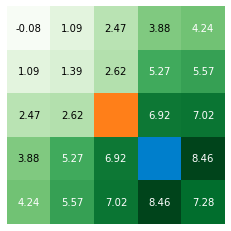

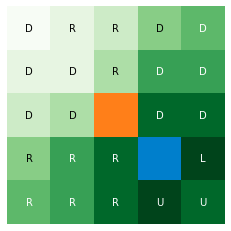

In [10]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld(object):
    def __init__(self, gridSize, items):
        self.step_reward = -1
        self.m = gridSize[0]
        self.n = gridSize[1]
        self.grid = np.zeros(gridSize)
        self.items = items

        self.state_space = list(range(self.m * self.n))

        self.action_space = {'U': -self.m, 'D': self.m, 'L': -1, 'R': 1}
        self.actions = ['U', 'D', 'L', 'R']

        self.P = self.int_P()

    def int_P(self):
        P = {}
        for state in self.state_space:
            for action in self.actions:
                reward = self.step_reward
                n_state = state + self.action_space[action]


                if n_state in self.items.get('fire').get('loc'):
                    reward += self.items.get('fire').get('reward')
                elif n_state in self.items.get('water').get('loc'):
                    reward += self.items.get('water').get('reward')
                elif self.check_move(n_state, state):
                    n_state = state

                P[(state ,action)] = (n_state, reward)
        return P

    def check_terminal(self, state):
        return state in self.items.get('fire').get('loc') + self.items.get('water').get('loc')

    def check_move(self, n_state, oldState):
        if n_state not in self.state_space:
            return True
        elif oldState % self.m == 0 and n_state % self.m == self.m - 1:
            return True
        elif oldState % self.m == self.m - 1 and n_state % self.m == 0:
            return True
        else:
            return False

def print_v(v, grid):
    v = np.reshape(v, (grid.n, grid.m))

    cmap = plt.cm.get_cmap('Greens', 100)
    norm = plt.Normalize(v.min(), v.max())
    rgba = cmap(norm(v))

    for w in grid.items.get('water').get('loc'):
        idx = np.unravel_index(w, v.shape)
        rgba[idx] = 0.0, 0.5, 0.8, 1.0

    for f in grid.items.get('fire').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.1, 1.0

    fig, ax = plt.subplots()
    im = ax.imshow(rgba, interpolation='nearest')

    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            c = 'w'
            if v[i, j] < 4: c = 'k'
            if v[i, j] != 0:
                text = ax.text(j, i, np.round(v[i, j], 2), ha="center", va="center", color=c)

    plt.axis('off')
    # plt.savefig('stochastic_v.jpg', bbox_inches='tight', dpi=200)
    plt.show()


def print_policy(v, policy, grid):
    v = np.reshape(v, (grid.n, grid.m))
    policy = np.reshape(policy, (grid.n, grid.m))

    cmap = plt.cm.get_cmap('Greens', 10)
    norm = plt.Normalize(v.min(), v.max())
    rgba = cmap(norm(v))

    for w in grid.items.get('water').get('loc'):
        idx = np.unravel_index(w, v.shape)
        rgba[idx] = 0.0, 0.5, 0.8, 1.0

    for f in grid.items.get('fire').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.1, 1.0

    fig, ax = plt.subplots()
    im = ax.imshow(rgba, interpolation='nearest')

    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            c = 'w'
            if v[i, j] < 4: c = 'k'
            if v[i, j] != 0:
                text = ax.text(j, i, policy[i, j], ha="center", va="center", color=c)

    plt.axis('off')
    # plt.savefig('stochastic_policy.jpg', bbox_inches='tight', dpi=200)
    plt.show()

def interate_values(grid, v , policy, gamma, theta, p_stoch):
    converged = False
    i = 0
    sp = p_stoch
    p = {'U': [sp+(1-sp)/4, (1-sp)/4, (1-sp)/4, (1-sp)/4],
         'D': [(1-sp)/4, sp+(1-sp)/4, (1-sp)/4, (1-sp)/4],
         'L': [(1-sp)/4, (1-sp)/4, sp+(1-sp)/4, (1-sp)/4],
         'R': [(1-sp)/4, (1-sp)/4, (1-sp)/4, sp+(1-sp)/4]}

    while not converged:
        DELTA = 0
        for state in grid.state_space:
            i += 1
            if  grid.check_terminal(state):
                v[state] = 0

            else:
                old_v = v[state]
                new_v = []
                for action in grid.actions:
                    new_v_p = []

                    for idx, action_p in enumerate(grid.actions):
                        (n_state, reward) = grid.P.get((state, action_p))
                        new_v_p.append(p.get(action)[idx] * (reward + (gamma * v[n_state])))

                    new_v.append(sum(new_v_p))

                v[state] = max(new_v)

                DELTA = max(DELTA, np.abs(old_v - v[state]))
                converged = True if DELTA < theta else False

    for state in grid.state_space:
        i += 1
        new_vs = []

        for action in grid.actions:
            (n_state, reward) = grid.P.get((state, action))
            new_vs.append(reward + gamma * v[n_state])

        new_vs = np.array(new_vs)
        best_action_idx = np.where(new_vs == new_vs.max())[0]
        policy[state] = grid.actions[best_action_idx[0]]

    print(i, 'iterations of state space')
    return v, policy

if __name__ == '__main__':

    grid_size = (7, 7)
    items = {'fire': {'reward': -10, 'loc': [12]},
             'water': {'reward': 10, 'loc': [18]},
             'wall': {'reward': 10, 'loc': [18]}}

    gamma = 1.0
    theta = 1e-10
    p_stoch = 0.7

    v = np.zeros(np.prod(grid_size))
    policy = np.full(np.prod(grid_size), 'n')

    env = GridWorld(grid_size, items)

    v, policy = interate_values(env, v, policy, gamma, theta, p_stoch)

    print_v(v, env)
    print_policy(v, policy, env)